<a href="https://colab.research.google.com/github/Laohachot/inf368-ex1/blob/master/Exercise_1_INF368.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remember to set runtime type with GPU acceleration

Runtime > Change runtime type > Hardware accelerator > GPU

In [0]:
seed=42069
import numpy as np
np.random.seed(seed)
from typing import Callable
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score
import re
import seaborn as sns
import gc
import time

import tensorflow as tf
tf.set_random_seed(seed)

import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, BatchNormalization, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


# Mutes all the tensorflow warnings
Don't run tensorflow_shutup if you want warnings


In [0]:
def tensorflow_shutup():
    """
    Make Tensorflow less verbose

    Source:
    https://stackoverflow.com/a/54950981
    """
    try:
        # noinspection PyPackageRequirements
        import os
        from tensorflow import logging
        logging.set_verbosity(logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        # Monkey patching deprecation utils to shut it up! Maybe good idea to disable this once after upgrade
        # noinspection PyUnusedLocal
        def deprecated(date, instructions, warn_once=True):
            def deprecated_wrapper(func):
                return func
            return deprecated_wrapper

        from tensorflow.python.util import deprecation
        deprecation.deprecated = deprecated

    except ImportError:
        pass

tensorflow_shutup()

Set model here

In [0]:
pretrained_body = MobileNetV2

## Obtain data

In [0]:
(X_train_raw, y_train_raw), (X_valtest_raw, y_valtest_raw) = cifar10.load_data()

X_train_pp = preprocess_input(X_train_raw)
X_valtest_pp = preprocess_input(X_valtest_raw)

print(f'''Train valtest shapes:

    X_train_raw: {X_train_raw.shape}
    y_train_raw: {y_train_raw.shape}
        
    X_valtest_raw: {X_valtest_raw.shape}
    y_valtest_raw: {y_valtest_raw.shape}''')

170500096/170498071 [==============================] - 2s 0us/step
Train valtest shapes:

    X_train_raw: (50000, 32, 32, 3)
    y_train_raw: (50000, 1)
        
    X_valtest_raw: (10000, 32, 32, 3)
    y_valtest_raw: (10000, 1)


Split into train test split

In [0]:
# Column to row 
y_train = y_train_raw.flatten()
y_valtest = y_valtest_raw.flatten()

# Split labels 
y_val = y_valtest[:5000]
y_test = y_valtest[5000:]

# Split data
X_val_pp = X_valtest_pp[:5000]
X_test_pp = X_valtest_pp[5000:]

X_val_raw = X_valtest_raw[5000:]
X_test_raw = X_valtest_raw[:5000]

del X_valtest_pp
del y_valtest

In [0]:
print(f'''Train val test shapes:

    X_train_pp: {X_train_pp.shape}
    y_train: {y_train.shape}
        
    X_val_pp: {X_val_pp.shape}
    y_val: {y_val.shape}
    
    X_test_pp: {X_test_raw.shape}
    y_val: {y_val.shape}''')

Train val test shapes:

    X_train_pp: (50000, 32, 32, 3)
    y_train: (50000,)
        
    X_val_pp: (5000, 32, 32, 3)
    y_val: (5000,)
    
    X_test_pp: (5000, 32, 32, 3)
    y_val: (5000,)


## Sanity check: inspect the data


In [0]:
# Dictionary from numeric class to actual names
namemap = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

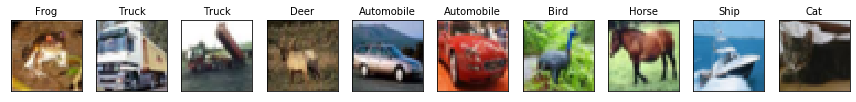

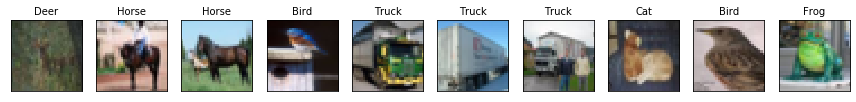

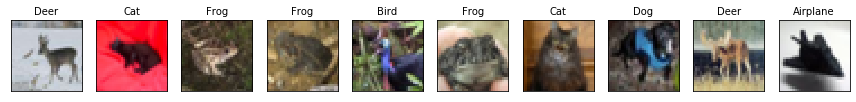

In [0]:
def show_imgs(X: np.ndarray, y: np.ndarray=None, shape: tuple='auto', figsize: tuple=(12,12), *args, **kwargs):
    '''
    Function to show that the data is not messed up
    '''
    if type(X) != np.ndarray: X = np.array(X)

    if shape == 'auto' and len(X.shape) > 2:
        shape = X.shape[1:]
    else:
        shape = (1, *X.shape)

    fig, axes = plt.subplots(1, X.shape[0], figsize=figsize)
    if type(axes) != np.ndarray: axes = (axes,)

    [ax.imshow(img.reshape(*shape), *args, **kwargs) for img, ax in zip(X, axes)]
    if not y is None: [ax.set_title(str(i), fontsize=10) for i, ax in zip(y, axes)]
    plt.setp(axes, yticks=[], xticks=[])
    fig.tight_layout()
    plt.show()

n_show = 10
n_rows = 3
for i in range(n_rows):
    idx = slice(i*n_show, (i+1)*n_show)
    show_imgs(X_train_raw[idx], [namemap[j] for j in y_train[idx]])

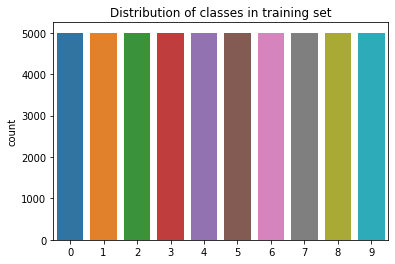

In [0]:
sns.countplot(y_train).set_title('Distribution of classes in training set')
plt.show()

Looks balanced to me, accuracy score it is!

## Try using ResNet50 as is 
Without altering the output layer, try to make the model predict images from cifar10

In [0]:
# ResNet50 is designed for 224 x 224 images
# Use an upscaler model (using bilinear method) to upscale images
upscaler_input = Input(shape=(32,32,3))
upscaler_upsampler = UpSampling2D(size=(7,7), input_shape=(32,32,3))(upscaler_input)
upscaler = Model(inputs=upscaler_input, outputs=upscaler_upsampler)

In [0]:
model1000 = pretrained_body(input_tensor=upscaler.output)

14540800/14536120 [==============================] - 0s 0us/step


40960/35363 [==================================] - 0s 0us/step


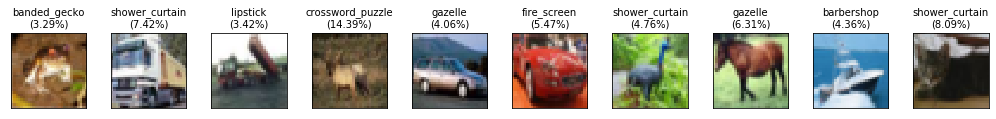

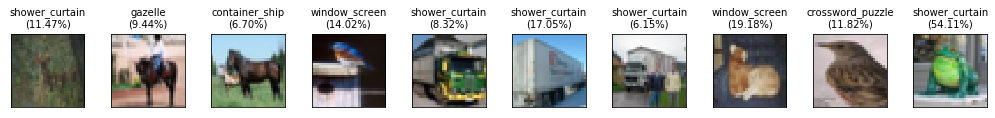

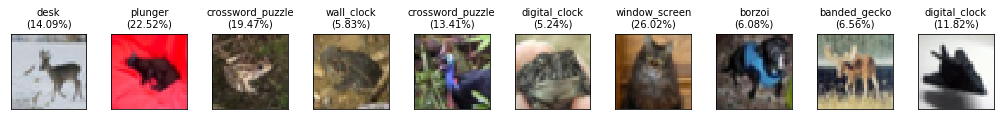

In [0]:
def test(images, raw_images):
    yhat = model1000.predict(images)
    labels = decode_predictions(yhat)
    preds = [f'{lab[0][1]}\n({lab[0][2]*100:.2f}%)' for lab in labels]
    upscaled_images = upscaler.predict(images).astype(int)
    show_imgs(raw_images, preds, figsize=(14,14))

for i in range(3):
    idx = slice(i*n_show, (i+1)*n_show)
    test(X_train_pp[idx], X_train_raw[idx])

At least it tried

Now, let us cut its head off and put on a more appropriate head for cifar10

## Surgery
1. Cut head off 
2. Put on new head with 10 classes

In [0]:
# Get a model without the dense layers, this also has the same
# upscaler for input.
model10 = pretrained_body(include_top=False, input_tensor=upscaler.output)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


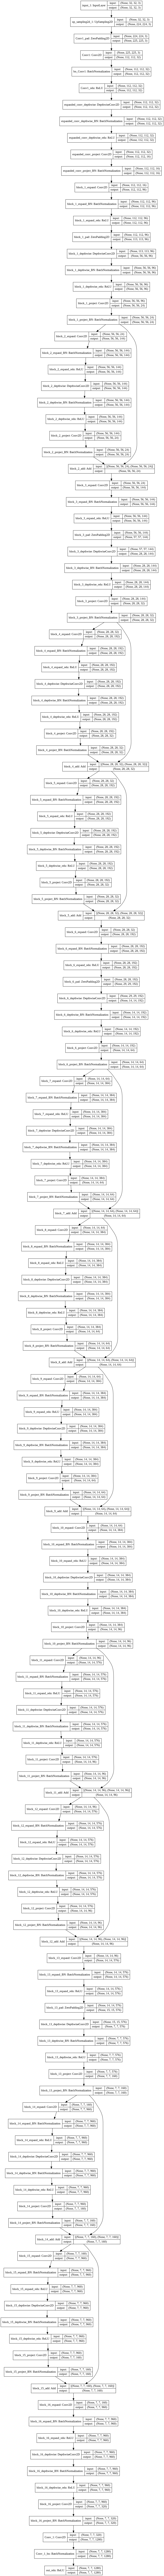

In [0]:
plot_model(model10, show_shapes=True)

In [0]:
# Delete if already exists, since system will run out of ram
try:
    del train_latent_vars
    del val_latent_vars
    gc.collect()
    print('Deleted latent vars')
except:
    gc.collect()

In [0]:
N_train = 50000
N_val = 5000

y_train_cnn = keras.utils.to_categorical(y_train[:N_train], 10)
y_val_cnn = keras.utils.to_categorical(y_val[:N_val], 10)

training_data = X_train_raw[:N_train]
validation_data = X_val_raw[:N_val]
training_labels = y_train_cnn
validation_labels = y_val_cnn

train_latent_vars = model10.predict(training_data)
val_latent_vars = model10.predict(validation_data)

We want to fine tune the replacement dense layer, a good idea is to store the activations from the last layer (for all the training samples) to disk. Then we dont need to pass the data through the whole network for every forward pass. However, doing so for the whole data set eats up a lot of disk place (almost 19GB) when storing as HDF5 or npy.

In [0]:
head_layers = [
    Flatten(),
    # Dense(30, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(10, activation='softmax')
]

def insert_head_seq(body):
    '''
    Using sequential API, connect head to body

    Returns model with head and body, and just head (same head that is on body)
    '''
    head = Sequential(head_layers, name='head_seq')
    return Model(inputs=body.input, outputs=head(body.output), name='frank'), head

def insert_head_func(body):
    '''
    Using functional API, connect head to body
    
    Returns model with head and body, and just head (DIFFERENT head from body).
    Idk how to get the same head
    '''
    def connect_layers(first_layer):
        head_input = head_output = first_layer
        for layer in head_layers:
            head_output = layer(head_output)
        return head_input, head_output

    head_input, head_output = connect_layers(Input(shape=body.output.shape[1:].as_list()))
    head = Model(inputs=head_input, outputs=head_output, name='head_func')
    
    head_input, head_output = connect_layers(body.output)
    full = Model(inputs=body.input, outputs=head_output, name='head_func2')
    return full, head

In [0]:
plot_model(frank, show_shapes=True)

NameError: ignored

In [0]:
# Freeze layers in model10
for layer in model10.layers:
    layer.trainable=False

frank, head = insert_head_seq(model10) 
head.compile(optimizer=Adam(lr=0.00006), loss='categorical_crossentropy', metrics=['accuracy'])
frank.compile(optimizer=Adam(lr=0.00006), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def evaluate(model, X, y):
    for metric, value in zip(model.metrics_names, model.evaluate(x=X, y=y)):
        print(f'{metric}: {value}')

def evaluate_graphic(model: 'KerasModel', images: np.ndarray, raw_images: np.ndarray, labels: np.ndarray, namemap: dict, figsize=(20,20)):
    '''Evaluate classification networks'''
    preds = model.predict(images)
    names = [f'{namemap[i]}\n({namemap[label]})' for i, label in zip(np.argmax(preds, axis=1), labels)]
    upscaled_images = upscaler.predict(raw_images).astype(int)
    show_imgs(upscaled_images, names, figsize=figsize)

Try to classify a few validation images without any training

In [0]:
offset = 0
n_show=16
for i in range(3):
    idx = slice(i*n_show+offset, (i+1)*n_show+offset)
    evaluate_graphic(model=frank, images=X_val_pp[idx], raw_images=X_val_raw[idx], labels=y_val[idx], namemap=namemap, figsize=(20,12))

In [0]:
# Before
evaluate(frank, validation_data, validation_labels)

Fit the head on the output from the body's output from training data. For some reason, training on the whole network is kind of buggy. It achieves to overfit (100% on train set) during training, but when evaluating on the train set externally (which should be exactly the same) it only achieves ~40%. 

In [0]:
head.fit(
    x=train_latent_vars, 
    y=training_labels,
    batch_size=256, 
    epochs=20,
    validation_data=(val_latent_vars, validation_labels),
)

In [0]:
# After
evaluate(frank, validation_data, validation_labels)

In [0]:
# The values for these are different for some versions of Keras or TensorFlow or 
# whatever
val_accuracy_key = 'val_acc'
accuracy_key = 'acc'

def generate_text(hist, paramdict: dict):
    '''Generates caption text for plot below'''
    best_idx = np.argmax(hist.history[val_accuracy_key])
    string = str(paramdict)
    string = re.sub('[{}\[\]\']', '', str(paramdict)) # Clears brackets and annotations
    string = string.replace(', ', ',\n') # Adds newlines
    string += f"\nBest and last val accs: \n{hist.history[val_accuracy_key][best_idx]:.4f} @ {best_idx+1} epochs"
    string += f"\n{hist.history[val_accuracy_key][-1]:.4f} @ {len(hist.history[val_accuracy_key])} epochs"
    return string

def plot_training_histories(training_histories, paramdict: dict=None, **kwargs):
    '''Plots given a list of keras training histories, gives a quick summary in plots as well'''
    fig, axes = plt.subplots(len(training_histories), 2, figsize=(12, 2.5*len(training_histories)))
    xepochs = np.arange(1, len(training_histories[0].history['loss'])+1)

    axes = axes.reshape(-1, 2)
    for i, hist in enumerate(training_histories):
        axes[i,0].plot(xepochs, hist.history['loss'], linestyle='--', **kwargs)
        axes[i,0].plot(xepochs, hist.history['val_loss'], **kwargs)    
        axes[i,1].plot(xepochs, hist.history[accuracy_key], linestyle='--', **kwargs)
        axes[i,1].plot(xepochs, hist.history[val_accuracy_key], **kwargs)

        if paramdict:
            axes[i,0].text(
                x=-0.55, 
                y=0.55, 
                s=generate_text(hist, paramdict[i]), 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=axes[i,0].transAxes,
                fontsize=12)
    
    axes[0,0].set_title("Train/Validation loss")
    axes[0,1].set_title("Train/Validation accuracy")
    axes[0,0].legend(['Train loss', 'Validation loss'])
    axes[0,1].legend(['Train accuracy', 'Validation accuracy'])
    plt.setp(axes[:,0], ylabel='Loss') # Left column
    plt.setp(axes[:,1], ylabel='Accuracy') # Right column
    plt.setp(axes[-1,:], xlabel='Epochs') # Last row
    plt.setp(axes, xticks=xepochs)

    plt.tight_layout()
    plt.show()

In [0]:
plot_training_histories([head.history])

Try on completely unseen data (test set)




In [0]:
test_data = X_test_raw 
test_labels_cnn = keras.utils.to_categorical(y_test)

In [0]:
evaluate(frank, test_data, test_labels_cnn)

In [0]:
offset = 0
n_show=16
for i in range(3):
    idx = slice(i*n_show+offset, (i+1)*n_show+offset)
    evaluate_graphic(frank, test_data[idx], y_test[idx], namemap, figsize=(20,12))

It performs similarly to validation set as it does on test set. Overall performance is not that great, but then again there has been no proper model selection. 